In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NLP/Project3/
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NLP/Project3
1/  2/  3/  dataset/  glove.6B.50d.txt  Project_3.ipynb  Project_show.ipynb


In [ ]:
import numpy as np
import pandas as pd 
import tensorflow as tf 
from keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import losses
from tensorflow.keras import backend
from tensorflow.keras import callbacks
import keras
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Input,Dropout
from keras.layers import concatenate,AveragePooling1D,GlobalMaxPooling1D

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [ ]:
train = load_doc('dataset/train_low.txt')
test = load_doc('dataset/test.txt')

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer


def remove_stop_words(value):
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')

    stop_words = set(stopwords.words('english'))

    word_tokens = word_tokenize(value)

    filtered_sentence = [word for word in word_tokens if word not in stopwords.words('english')]

    filtered_sentence = []

    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    return TreebankWordDetokenizer().detokenize(filtered_sentence).replace('\\', '')

In [ ]:
import nltk
nltk.download('stopwords')
train=remove_stop_words(train)
test=remove_stop_words(test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tokenizer_train = Tokenizer()
tokenizer_train.fit_on_texts([train])
encoded_train = tokenizer_train.texts_to_sequences([train])[0]

tokenizer_test = Tokenizer()
tokenizer_test.fit_on_texts([test])
encoded_test = tokenizer_test.texts_to_sequences([test])[0]

In [ ]:
vocab_size_train = len(tokenizer_train.word_index) + 1
print('Vocabulary Size: %d' % vocab_size_train)

vocab_size_test = len(tokenizer_test.word_index) + 1
print('Vocabulary Size: %d' % vocab_size_test)

Vocabulary Size: 15301
Vocabulary Size: 6290


In [ ]:
#five gram

sequences_train = list()
for i in range(4, len(encoded_train)):
    sequence_train = encoded_train[i-3:i+2]
    sequences_train.append(sequence_train)
print('Total Sequences train: %d' % len(sequences_train))    

sequences_test = list()
for i in range(4, len(encoded_test)):
    sequence_test = encoded_test[i-3:i+2]
    sequences_test.append(sequence_test)
print('Total Sequences test: %d' % len(sequences_test))    

Total Sequences train: 57048
Total Sequences test: 12344


In [ ]:
max_length_train = max([len(seq) for seq in sequences_train])
sequences_train = pad_sequences(sequences_train, maxlen=max_length_train, padding='pre')
print('Max Sequences train Length: %d' % max_length_train)

max_length_test = max([len(seq) for seq in sequences_test])
sequences_test = pad_sequences(sequences_test, maxlen=max_length_test, padding='pre')
print('Max Sequences test Length: %d' % max_length_test)

Max Sequences train Length: 5
Max Sequences test Length: 5


In [ ]:
sequences_train = np.array(sequences_train)
X_train, y_train = sequences_train[:,:-1],sequences_train[:,-1]

sequences_test = np.array(sequences_test)
X_test, y_test = sequences_test[:,:-1],sequences_test[:,-1]

In [ ]:
y_train = to_categorical(y_train, num_classes=vocab_size_train)

In [ ]:
y_test = to_categorical(y_test, num_classes=vocab_size_train)

In [ ]:
def perplexity(y_true, y_pred):
    cross_entropy = losses.categorical_crossentropy(y_true, y_pred)
    perplexity = backend.pow(2.0, cross_entropy)
    return perplexity

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size_train, 50, name="embedding",input_length=max_length_train-1))
model.add(Flatten())
model.add(Dense(35, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(vocab_size_train, activation='softmax'))

gd=tf.keras.optimizers.SGD(
    learning_rate=0.02,
    name='SGD'
)

model.compile(loss='categorical_crossentropy', optimizer=gd, metrics=[perplexity])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 50)             765050    
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 35)                7035      
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15301)             550836    
Total params: 1,322,921
Trainable params: 1,322,921
Non-trainable params: 0
______________________________________________

In [ ]:
metrics = model.fit(X_train, y_train, validation_data=(x_dev,y_dev), epochs=100, batch_size=25)

Epoch 1/100
2282/2282 [==============================] - 9s 3ms/step - loss: 9.5020 - perplexity: 761.5888
Epoch 2/100
2282/2282 [==============================] - 7s 3ms/step - loss: 9.2321 - perplexity: 696.6583
Epoch 3/100
2282/2282 [==============================] - 7s 3ms/step - loss: 9.0745 - perplexity: 656.2572
Epoch 4/100
2282/2282 [==============================] - 7s 3ms/step - loss: 8.9477 - perplexity: 635.4925
Epoch 5/100
2282/2282 [==============================] - 7s 3ms/step - loss: 8.8382 - perplexity: 622.6003
Epoch 6/100
2282/2282 [==============================] - 7s 3ms/step - loss: 8.7720 - perplexity: 619.6910
Epoch 7/100
2282/2282 [==============================] - 7s 3ms/step - loss: 8.7312 - perplexity: 620.7856
Epoch 8/100
2282/2282 [==============================] - 7s 3ms/step - loss: 8.6848 - perplexity: 618.2501
Epoch 9/100
2282/2282 [==============================] - 7s 3ms/step - loss: 8.6546 - perplexity: 619.8984
Epoch 10/100
2282/2282 [=============

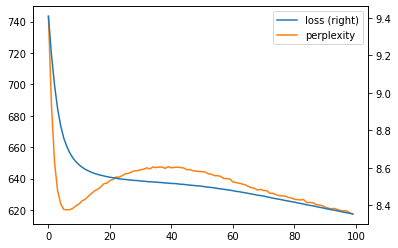

In [ ]:
result = pd.DataFrame.from_dict(metrics.history)
result.plot.line(secondary_y=["loss", "val_loss"])

In [ ]:
print(model.evaluate(X_test,y_test))

386/386 [==============================] - 1s 3ms/step - loss: 8.6329 - perplexity: 560.2018
[8.632889747619629, 560.2017822265625]
